In [1]:
import os, sys
mainPath = os.path.dirname(os.path.abspath(".")) + "/.."
sys.path.append(mainPath)

In [3]:
from figures.roicat_figure.pair_of_pairs import PairPairDatahandler, PairPairInteractivePlot, plot_pair_example_figure

# for choosing a pair of pairs to highlight spatial feature discrimination
mouse_name = "ATL027"
# pp_handler = PairPairDatahandler(mouse_name, fake_data=False)
# pp_window = PairPairInteractivePlot(pp_handler)
# pp_window.show()

In [ ]:
# Saving some good possibilities for the figure (no plane 0):
# ATL027, sessions 10/11, Match Idx: [1878 1603] NoMatch Idx: [2433 2652]
# ATL027, sessions 8/9, Match Idx: [11079  8659] NoMatch Idx: [13208 11206]
# ATL027, sessions 8/9, Match Idx: [7640 5003] NoMatch Idx: [10729  5743]

# lost possibility:
# ATL027, sessions 8/9, they were in rough centroid [310, 60-80], the match had a place field > 180cm.

# Possibilities (no plane 0):
# ATL027, sessions 9/10, Match Idx: [11828 13054] NoMatch Idx: [9393 9689]
# ATL027, sessions 9/10, Match Idx: [4984 5500] NoMatch Idx: [5098 7138]
# ATL027, sessions 9/11, Match Idx: [265 524] NoMatch Idx: [132 891]

# ATL027: Sessions: [ 8 10], Matched ROIs: [4267 1992], Non-matched ROIs: [5458 2224], Plane Pair: 2

In [ ]:
vars(pp_handler)

In [ ]:
plot_pair_example_figure(pp_handler, isespair, idxroipair, roi_scale, zscore_lim, range, save=False)

In [ ]:
from _old_vrAnalysis import analysis, tracking

mouse_name = "ATL027"
roistat = analysis.RoicatStats(tracking.tracker(mouse_name)) # only make this once so data stays loaded

In [ ]:
# make snake plot of all tracked cells that are reliable in the "sortby" session
envnum, idx_ses = roistat.env_idx_ses_selector(envmethod="most", sesmethod=-7, verbose=True)
outs = roistat.plot_snake(envnum, idx_ses=idx_ses, sortby=idx_ses[-4], cutoffs=(0.4, 0.7), normalize=-80, rewzone=True, sortby_blue=False, height_multiplier=2.0, withSave=True)

In [88]:
# Let's reset this analysis pipeline with a Syd viewer. 
import numpy as np
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import matplotlib as mpl
from syd import Viewer

from vrAnalysis.tracking import Tracker
from vrAnalysis.multisession import MultiSessionSpkmaps
from vrAnalysis import helpers

In [133]:
# Set up a mouse to look at
mouse_name = "ATL027"
tracker = Tracker(mouse_name)
msm = MultiSessionSpkmaps(tracker)

# And look at the env_stats
env_stats = msm.env_stats()
for env in sorted(env_stats, key=lambda x: env_stats[x][0]):
    print("Env:", env, "--- Sessions:", env_stats[env])

Env: 3 --- Sessions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Env: 1 --- Sessions: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Env: 4 --- Sessions: [11, 12, 13]


In [134]:
# Define dataset
envnum = 3
idx_ses = [i for i in range(7, 14)]

# Get spkmaps
spkmaps, extras = msm.get_spkmaps(envnum, average=True, idx_ses=idx_ses)

C:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\multisession.py:326: RuntimeWarning: Mean of empty slice
  spkmaps = [np.nanmean(s, axis=1) for s in spkmaps]


In [ ]:
def moment_width_linear(R, x, axis=1):
    R = np.asarray(R)
    if axis != 1: R = np.swapaxes(R, axis, 1)
    w = R.sum(axis=1, keepdims=True) + 1e-12
    mu = (R @ x) / w.squeeze(1)
    var = ((R * (x - mu[:, None])**2).sum(axis=1) / w.squeeze(1))
    return np.sqrt(var)

In [149]:
# Choose and sort ROIs
rel_cutoff = 0.3
idx_reference = len(idx_ses) // 2

mwl = moment_width_linear(spkmaps[idx_reference], extras['positions'], axis=1)
idx_include = (extras['reliability'][idx_reference] > rel_cutoff) & (mwl > 25)
idx_sorted = np.argsort(extras['pfloc'][idx_reference][idx_include])

C:\Users\Andrew\AppData\Local\Temp\ipykernel_1920\479175860.py:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(var)


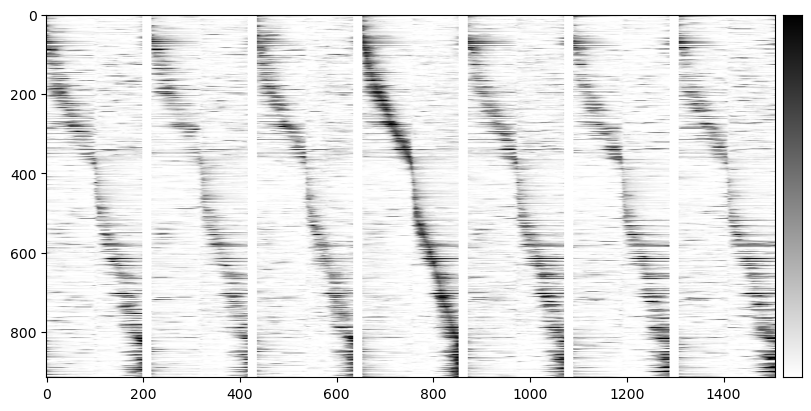

In [155]:
# Make a single heatmap of all the spkmaps with a designated space in between them
size_separation = spkmaps[0].shape[1] // 10 # for 10% separation...
separator = np.full((np.sum(idx_include), size_separation), np.nan)
all_arrays = [arr for smap in spkmaps[:-1] for arr in (smap[idx_include][idx_sorted], separator)] + [spkmaps[-1][idx_include][idx_sorted]]
all_maps_sorted = np.concatenate(all_arrays, axis=1)


cmap = mpl.colormaps["gray_r"]
cmap.set_bad("white")
cmap_as_array = np.flipud(cmap(np.linspace(0, 1, 256)))[:, np.newaxis]

# Plot
vmax = 2
plt.close('all')
fig, ax = plt.subplots(1, 2, width_ratios=[1, 0.025], figsize=(8, 4), layout="constrained")
ax[0].imshow(all_maps_sorted, cmap=cmap, aspect='auto', vmin=0, vmax=vmax)
ax[1].imshow(cmap_as_array, aspect='auto')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

In [ ]:
# Next get the same / different correlation working
# Then the correlation by silhouette score? 

In [ ]:
# What do I need? 
# 1. Define a pair of sessions and an environment choice
# 2. Get spkmaps
# 2.1 Get locations
# 2.2 Get reliabilities
# 3. Get pairs of ROIs
# 4. Get map of ROI pairs that are "matched"
# 5. Get map of ROI pairs that are "not matched"
# 6. Plot local ROI image of each session

In [48]:
idx_ses = [10, 13]
idx_rois = [msm.processors[i].session.idx_rois for i in idx_ses] # Which ROIs to keep based on session criteria
spkmaps, extras = msm.get_spkmaps(3, average=True, tracked=False, use_session_filters=False, idx_ses=idx_ses) # Get spkmaps for each session (and reliability in extras)
roi_positions = [tracker.sessions[i].get_roi_position() for i in idx_ses] # Get ROI positions for each session
idx_tracked, tracking_extras = tracker.get_tracked_idx(idx_ses=idx_ses, use_session_filters=False) # Get tracking info for each session
print([s.shape for s in spkmaps], [s.shape for s in roi_positions], idx_tracked.shape)

C:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\multisession.py:326: RuntimeWarning: Mean of empty slice
  spkmaps = [np.nanmean(s, axis=1) for s in spkmaps]


[(17199, 199), (16318, 199)] [(17199, 3), (16318, 3)] (2, 10739)


In [ ]:
roicat_labels = [np.full(s.shape[0], np.nan) for s in spkmaps]
for ii in range(2):
    roicat_labels[ii][idx_tracked[ii]] = tracking_extras["cluster_ids"]

# Let's use the fact that we can ignore off-plane pairs to speed this up
# (Get list of unique planes, filter groups of pairs by plane, then do each pairwise comparison for each plane independently, and flatten and stack)
# (We'll have a (2xnumPairs) array of the index of each ROI from each session for identification!)
idx_samecell_pair = roicat_labels[0].reshape(-1, 1) == roicat_labels[1].reshape(1, -1)
idx_sameplane_pair = roi_positions[0][:, -1].reshape(-1, 1) == roi_positions[1][:, -1].reshape(1, -1)
distance_pair = np.linalg.norm(roi_positions[0][:, :2].reshape(-1, 1, 2) - roi_positions[1][:, :2].reshape(1, -1, 2), axis=2)
correlation = helpers.crossCorrelation(spkmaps[0].T, spkmaps[1].T)

In [52]:
# Output Goal:
# Syd viewer with following options:
# Mouse
# Environment
# Session Pair (probably with predefined dropdown? or using a source/target group?)
# Then once this is picked, we do a cached option generation of the above stuff where we grab
# the pairs and make a list of possibilities
# Once we have pairs and possibilities, we use distance / correlation filtering to get a reduced list of candidates for "match" and "no match"
# And plot it. 

In [54]:
# But!!!!
# This pair pair code can be after... I think my other code is good enough for Rich for now. So I should just focus on that which should be easy...